In [131]:
using Flux
using ReinforcementLearning
using StatsBase:mean
using Plots
using Zygote
using LinearAlgebra
using Base.Iterators
using Random
using Colors
using ColorBrewer

┌ Info: Precompiling ColorBrewer [a2cac450-b92f-5266-8821-25eda20663c8]
└ @ Base loading.jl:1260


In [2]:
Base.@kwdef mutable struct αsPerEpisode <: AbstractHook
    αs::Vector{Array{Float64}} = Float64[]
    tag::String = "TRAINING"
end

function (hook::αsPerEpisode)(
    ::Union{PostEpisodeStage,PostExperimentStage},
    agent,
    env,
    obs,
)
    push!(hook.αs, softmax(deepcopy(agent.policy.learner.approximator.model.weights)))
    #println(softmax(deepcopy(agent.policy.learner.approximator.model.weights)))
    @debug hook.tag ALPHAS_PER_EPISODE = hook.αs[end]
end

Base.@kwdef mutable struct wsPerEpisode <: AbstractHook
    ws::Vector{Array{Float64}} = Float64[]
    tag::String = "TRAINING"
end


function (hook::wsPerEpisode)(
    ::Union{PostEpisodeStage,PostExperimentStage},
    agent,
    env,
    obs,
)
    flat_ps, re = Flux.destructure(deepcopy(agent.policy.learner.approximator.model))
    push!(hook.ws, flat_ps)
    @debug hook.tag WEIGHTS_PER_EPISODE = hook.ws[end]
end

In [3]:
ConvChain(input, hd1, output) =  Chain(
                    Dense(input, hd1, relu),
                    Dense(hd1, output),
                ) 

DenseChain(input, hd1, output) =  Chain(
                    Dense(input, hd1, relu),
                    Dense(hd1, output),
                ) 

DenseChain(input, hd1, hd2, output) =  Chain(
                    Dense(input, hd1, relu),
                    Dense(hd1, hd2, relu),
                    Dense(hd2, output),
                ) 


DenseChain (generic function with 2 methods)

In [4]:
struct Op
    chain
end

(m::Op)(x) = m.chain(x)

Flux.@functor Op


In [457]:
function squeeze(A::AbstractArray)
    #print(A, " ", size(A))
    if ndims(A) == 3
        if size(A, 3) == 32
            return dropdims(A; dims = (1))
        elseif size(A, 3) == 1
            return dropdims(A; dims = (1,3))
        end
    elseif ndims(A) == 4
        if size(A, 4) == 32
            return dropdims(A; dims = (1,2))
        elseif size(A, 4) == 1
            return dropdims(A; dims = (1,2,4))
        end
    end
    return A
end
            
function get_size(A::AbstractArray)
    print("\tsize:", size(A), "\t")
    return A
end
                   

get_size (generic function with 1 method)

In [458]:
struct MixOp
    weights::Array{Float32}
    chains::Array{Op}
end


function MixOp(input::Int64, output::Int64) 
    chains = [
            Op(Chain(x->reshape(x, 4, 1, :), 
                     Conv((4,), 1=>2,),
                     x -> relu.(x),
                     x -> squeeze(x)
                     )),
            Op(Chain(x->reshape(x, 4, 1, :), 
                     Conv((3,), 1=>8,),
                     x -> relu.(x),
                     Conv((2,), 8=>2,),
                     x -> relu.(x),
                     x -> squeeze(x)
                     )),
            Op(Chain(x->reshape(x, 4, 1, 1, :), 
                     x->reshape(x, 2, 2, 1, :), 
                     Conv((2,2), 1=>2,),
                     x -> relu.(x),
                     x -> squeeze(x)
                     )),
            Op(Chain(x->reshape(x, 4, 1, 1, :),
                     x->repeat(x, inner = [1, 4, 1, 1]), 
                     Conv((3,3), 1=>8,),
                     x -> relu.(x),
                     Conv((2,2), 8=>2),
                     x -> relu.(x),
                     x -> squeeze(x)
                     ))
            ]
    weights = softmax(ones(Float32,size(chains)))
    MixOp(weights,chains)
end

function (m::MixOp)(x)
    #println()
    #print(size(x), "; ")
    #[print(size(chain(x)), ", ") for chain in m.chains]
    mpw = softmax(m.weights)
    #println(sum([chain(x) for chain in m.chains].*mpw))
    sum([chain(x) for chain in m.chains].*mpw)
end

Flux.@functor MixOp

In [538]:
struct LayeredOp
    weights::Array{Float32, 2}
    chains::Array{Op,2}
end

#add in skip connections?

function LayeredOp(input::Int64, output::Int64) 
    l1 = [
            Op(Chain(x -> repeat(x, inner = [1, 1, 8, 1]),
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((1,1), 1=>8, pad = (0,0)),
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((3,3), 1=>8, pad = (1,1)),
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((5,5), 1=>8, pad = (2,2)),
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((3,3), 1=>4, pad = (1,1)),
                     x -> relu.(x),
                     Conv((3,3), 4=>8, pad = (1,1)),
                     x -> relu.(x),
                     )),]
    l2 = [
            Op(Chain(x -> x[1:2:end,1:2:end,:,:]+x[2:2:end,2:2:end,:,:], #change to maxpool?
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((1,1), 8=>8, stride=(2,2), pad = (0,0)),
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((3,3), 8=>8, stride=(2,2), pad = (1,1)),
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((5,5), 8=>8, stride=(2,2), pad = (2,2)),
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((3,3), 8=>8, pad = (1,1)),
                     x -> relu.(x),
                     Conv((3,3), 8=>8, stride=(2,2), pad = (1,1)),
                     x -> relu.(x),
                     )),]
    l3 = [
            Op(Chain(x -> x[1:2:end,1:2:end,1:4:end,:]
                            +x[2:2:end,2:2:end,2:4:end,:]
                            +x[1:2:end,1:2:end,3:4:end,:]
                            +x[2:2:end,2:2:end,2:4:end,:], #change to maxpool?
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((1,1), 8=>2, stride=(2,2), pad = (0,0)),
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((3,3), 8=>2, stride=(2,2), pad = (1,1)),
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((5,5), 8=>2, stride=(2,2), pad = (2,2)),
                     x -> relu.(x),
                     )),
            Op(Chain(Conv((3,3), 8=>4, pad = (1,1)),
                     x -> relu.(x),
                     Conv((3,3), 4=>2, stride=(2,2), pad = (1,1)),
                     x -> relu.(x),
                     )),
            
            ]
    chains = [l1 l2 l3]
    #print(size(chains))
    weights = softmax(ones(Float32,size(chains)))
    LayeredOp(weights,chains)
end

function (m::LayeredOp)(x)
    x = repeat(reshape(x, 4, 1, 1, :), inner = [1, 4, 1, 1])
    #println(size(m.weights))
    for i = 1:size(m.weights,2)
        mpw = softmax(m.weights[:,i])
        #[print(size(chain(x))) for chain in m.chains[:,i]]
        #println()
        x = sum([chain(x) for chain in m.chains[:,i]].*mpw)
    end
    squeeze(x)
end

Flux.@functor LayeredOp

In [534]:
arr = [[α,β,γ] for α in 0:1 for β in 0:1 for γ in 0:1]


8-element Array{Array{Int64,1},1}:
 [0, 0, 0]
 [0, 0, 1]
 [0, 1, 0]
 [0, 1, 1]
 [1, 0, 0]
 [1, 0, 1]
 [1, 1, 0]
 [1, 1, 1]

In [460]:
train()

(5, 3)

Progress:   1%|▎                                        |  ETA: 1:03:19

InterruptException: InterruptException:

In [461]:
struct DARTSLearner{Q,F,R} <: AbstractLearner
    approximator::Q
    loss_func::F
    γ::Float32
    batch_size::Int
    min_replay_history::Int
    rng::R
    ξ::Float32
end

(learner::DARTSLearner)(obs) =
    obs |> get_state |>
    x ->
        send_to_device(device(learner.approximator), x) |> learner.approximator |>
        send_to_host

function DARTSLearner(;
    approximator::Q,
    loss_func::F,
    γ = 0.99f0,
    batch_size = 32,
    min_replay_history = 32,
    seed = nothing,
    first = false 
) where {Q,F}
    rng = MersenneTwister(seed)
    first ? ξ = 0 : ξ = approximator.optimizer.eta 
    DARTSLearner{Q,F,typeof(rng)}(
        approximator,
        loss_func,
        γ,
        batch_size,
        min_replay_history,
        rng,
        ξ
    )
end

DARTSLearner

In [150]:
function flatten_grads(grads)
    xs = Zygote.Buffer([])
    fmap(grads) do x
        x isa AbstractArray && push!(xs, x)
        #println("x ",x)
        return x
    end
    flat_gs = vcat(vec.(copy(xs))...)
end



function my_update!(opt, ps::Params, gs)
  for (p, g) in zip(ps, gs)
    g == nothing && continue
    Flux.Optimise.update!(opt, p, g)
  end
end

my_update! (generic function with 1 method)

In [151]:
function params_(chains)
    ps = Params()
    for chain in chains
        Flux.params!(ps,chain)
    end
    return ps
end

function RLBase.update!(learner::DARTSLearner, batch) 
    Q, γ, loss_func, batch_size =
        learner.approximator, learner.γ, learner.loss_func, learner.batch_size
    s, r, t, s′ = map(
        x -> send_to_device(device(Q), x),
        (batch.state, batch.reward, batch.terminal, batch.next_state),
    )
    a = CartesianIndex.(batch.action, 1:batch_size)
    
    
    function grad(Q_, ps, verbose = false)
        gs = gradient(ps) do
            q = batch_estimate(Q_, s)[a]
            if verbose
                println("q: ", q)
            end
            q′ = vec(maximum(batch_estimate(Q_, s′); dims = 1))
            if verbose
                println("q': ", q')
            end
            G = r .+ γ .* (1 .- t) .* q′
            if verbose
                println("G: ", G)
            end
            loss_func(G, q)
        end
        return gs
    end

    w = params_(Q.model.chains)
    α = params(Q.model.weights)
    gsα = grad(Q, α)
    #println(gsα[params(Q.model.weights)])                
    if learner.ξ != 0
        Q_prime = deepcopy(Q)
        Q_prime_α = deepcopy(Q_prime)
        w_prime = params_(Q_prime.model.chains)

        gsw_prime = grad(Q_prime, w_prime)
        for a in params(Q_prime.model.chains).order
            #println(" gsw_prime ", norm(gsw_prime[a]))
        end

        Flux.Optimise.update!(Descent(learner.ξ), w_prime, gsw_prime)

        Q_prime_minus = deepcopy(Q_prime)

        w_prime_minus = params_(Q_prime_minus.model.chains)

        gsw_prime_minus = grad(Q_prime_minus, w_prime_minus)
        for a in params(Q_prime_minus.model.chains).order
            #println(" gsw_prime_minus ", norm(gsw_prime_minus[a]))
        end

        Q_minus = deepcopy(Q)
        Q_plus = deepcopy(Q)

        w_minus = params_(Q_minus.model.chains)
        w_plus = params_(Q_plus.model.chains)

        epsilon = 0.01 ./ norm([gsw_prime_minus[w] for w in w_prime_minus.order if gsw_prime_minus[w] != nothing])
        my_update!(Descent(epsilon), w_minus, [gsw_prime_minus[w] for w in w_prime_minus.order])
        my_update!(Descent(-1*epsilon), w_plus, [gsw_prime_minus[w] for w in w_prime_minus.order])
        
        gsα_prime = grad(Q_prime_α, params(Q_prime_α.model.weights))
        
        gsα_plus = grad(Q_plus, params(Q_plus.model.weights))
        gsα_minus = grad(Q_minus, params(Q_minus.model.weights))
                        
        for a in params(Q_prime_α.model.weights).order
            #println(a, " gsα_prime ", gsα_prime[a])
        end
                        
        for a in params(Q_plus.model.weights).order
            #println(gsα_plus[a])                
        end
                        
        my_update!(Q.optimizer, α, [gsα_prime[a] for a in params(Q_prime_α.model.weights).order])
        
        my_update!(Descent(-1*learner.ξ^2/(2*epsilon)), α, [gsα_plus[a] for a in params(Q_plus.model.weights).order])
        my_update!(Descent(learner.ξ^2/(2*epsilon)), α, [gsα_minus[a] for a in params(Q_minus.model.weights).order])
    else
        Flux.Optimise.update!(Q.optimizer, α, gsα)
    end
    gsw = grad(Q, w)
    Flux.Optimise.update!(Q.optimizer, w, gsw)
end

function RLBase.extract_experience(
    t::CircularCompactSARTSATrajectory,
    learner::DARTSLearner,
)
    if length(t) > learner.min_replay_history
        inds = rand(learner.rng, 1:length(t), learner.batch_size)
        map(get_trace(t, :state, :action, :reward, :terminal, :next_state)) do x
            consecutive_view(x, inds)
        end
    else
        nothing
    end
end

In [536]:
function train(;first_order = false) 
    env = CartPoleEnv(; T = Float32, seed = 11)
    ns, na = length(rand(get_observation_space(env))), length(get_action_space(env))
    Random.seed!(11)
    agent = Agent(
        policy = QBasedPolicy(
            learner = DARTSLearner(
                approximator = NeuralNetworkApproximator(
                    model = LayeredOp(ns,na),
                    optimizer = ADAM(),
                ),
                batch_size = 32,
                min_replay_history = 100,
                loss_func = huber_loss,
                seed = 22,
                first = first_order
            ),
            explorer = EpsilonGreedyExplorer(
                kind = :exp,
                ϵ_stable = 0.01,
                decay_steps = 500,
                seed = 33,
            ),
        ),
        trajectory = CircularCompactSARTSATrajectory(
            capacity = 1000,
            state_type = Float32,
            state_size = (ns,),
        ),
    )
    hook = ComposedHook(TotalRewardPerEpisode(), TimePerStep(), αsPerEpisode(), wsPerEpisode())
    run(agent, env, StopAfterStep(40000), hook)
    return hook
end

train (generic function with 1 method)

In [539]:
hook_2 = train(first_order=false)
hook_1 = train(first_order=true)


Progress: 100%|█████████████████████████████████████████| Time: 1:54:39
Progress: 100%|█████████████████████████████████████████| Time: 0:29:55


ComposedHook{Tuple{TotalRewardPerEpisode,TimePerStep,αsPerEpisode,wsPerEpisode}}((TotalRewardPerEpisode([13.0, 9.0, 13.0, 27.0, 13.0, 26.0, 22.0, 13.0, 10.0, 11.0  …  200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0], 133.0, "TRAINING"), TimePerStep([0.036493909, 0.039977293, 0.04324565, 0.038097024, 0.04220597, 0.039033411, 0.036457758, 0.0391517, 0.037858908, 0.037104384  …  0.04377281, 0.041317314, 0.038962402, 0.039333128, 0.039375505, 0.038365325, 0.044205657, 0.040219307, 0.037416224, 0.039718839], 0x000230186105a204), αsPerEpisode(Array{Float64,N} where N[[0.20000000298023224 0.20000000298023224 0.20000000298023224; 0.20000000298023224 0.20000000298023224 0.20000000298023224; … ; 0.20000000298023224 0.20000000298023224 0.20000000298023224; 0.20000000298023224 0.20000000298023224 0.20000000298023224], [0.20000000298023224 0.20000000298023224 0.20000000298023224; 0.20000000298023224 0.20000000298023224 0.20000000298023224; … ; 0.20000000298023224 0.200000002980

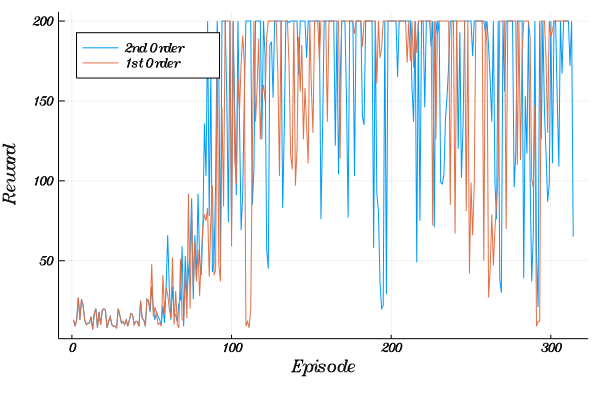

In [540]:
plot(hook_2[1].rewards, xlabel="Episode", ylabel="Reward", label="2nd Order",legend=:topleft)
plot!(hook_1[1].rewards, label="1st Order")

In [493]:
(hcat(hook_2[3].αs...)')[:,1]
[a[1,1] for a in hook_2[3].αs]

183-element Array{Float64,1}:
 0.20000000298023224
 0.20000000298023224
 0.20000000298023224
 0.20000000298023224
 0.1993350386619568
 0.19756025075912476
 0.19544938206672668
 0.19463062286376953
 0.1941564977169037
 0.19256281852722168
 0.19221627712249756
 0.1914491057395935
 0.19022372364997864
 ⋮
 0.06550496071577072
 0.06386486440896988
 0.0639907717704773
 0.06329245120286942
 0.0589824840426445
 0.05555165931582451
 0.05348209664225578
 0.051272425800561905
 0.050318337976932526
 0.05084700509905815
 0.05029608681797981
 0.050214800983667374

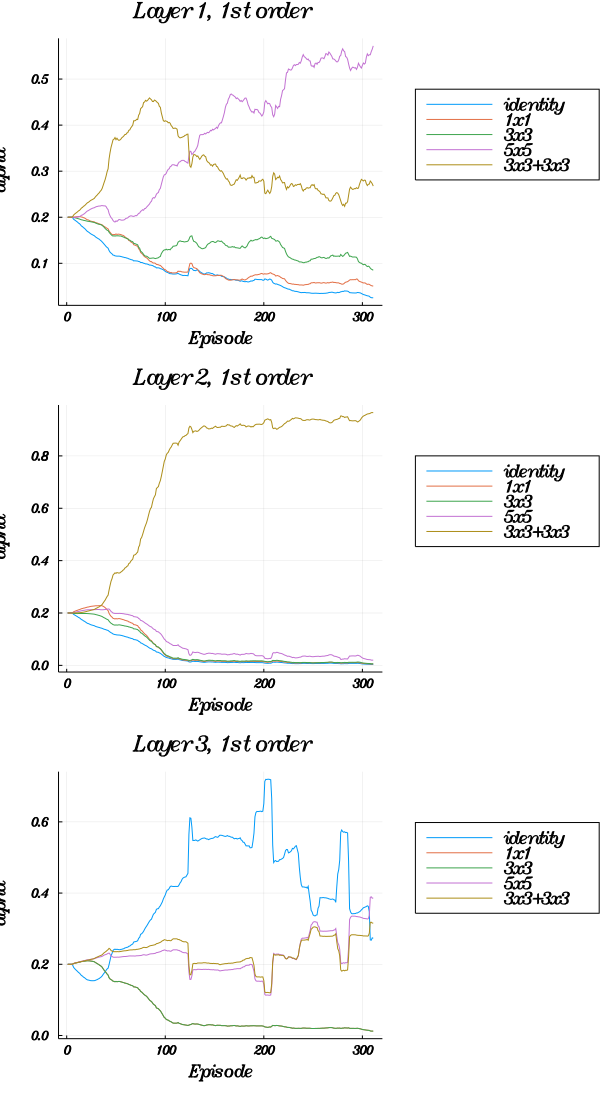

In [542]:
cur_colors = get_color_palette(:auto, plot_color(:white), 17)
labels = ["identity" "1x1" "3x3" "5x5" "3x3+3x3"]
p = Vector(undef, 3)
for j = 1:3
    p[j] = plot(title = "Layer $j, 1st order", legend = :outertopright)
    for i = 1:5
        plot!([a[i,j] for a in hook_1[3].αs], xlabel="Episode", ylabel="alpha",label=labels[i])#labels=["2nd:1dConv 1 layer" "2nd:1dConv 2 layer" "2nd:2dConv 1 layer" "2nd:2dConv 2 layer"], legend=:right)
        #plot!([a[i,j] for a in hook_1[3].αs], xlabel="Episode", ylabel="alpha",)#labels=["1st:1dConv 1 layer" "1st:1dConv 2 layer" "1st:2dConv 1 layer" "1st:2dConv 2 layer"])
    end
end
plot(p..., layout = (3,1), size = (600,1100))

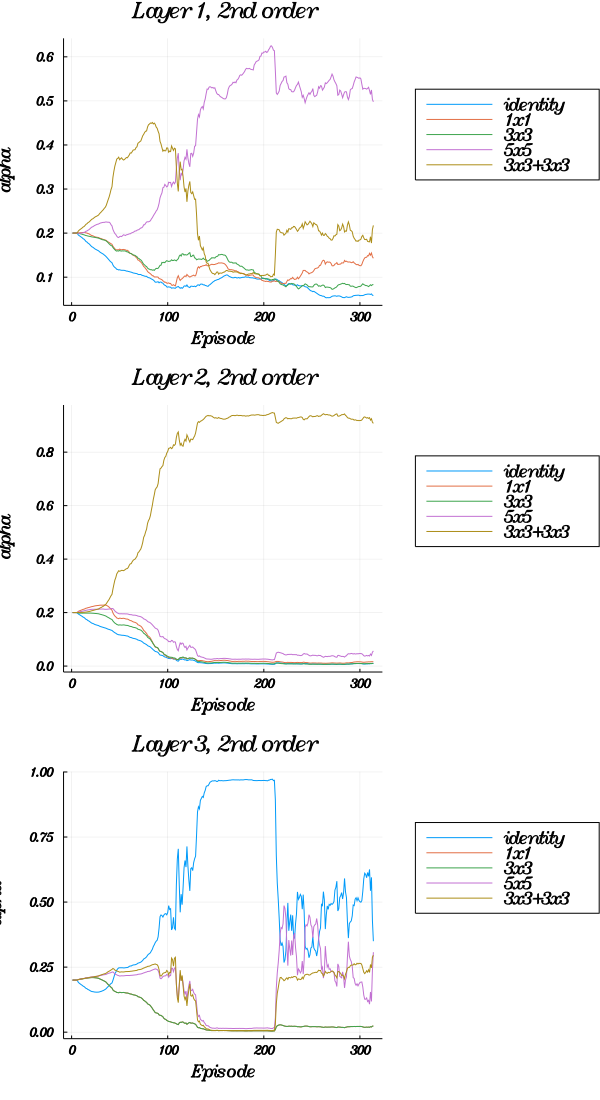

In [543]:
cur_colors = get_color_palette(:auto, plot_color(:white), 17)
labels = ["identity" "1x1" "3x3" "5x5" "3x3+3x3"]
p = Vector(undef, 3)
for j = 1:3
    p[j] = plot(title = "Layer $j, 2nd order", legend = :outertopright)
    for i = 1:5
        plot!([a[i,j] for a in hook_2[3].αs], xlabel="Episode", ylabel="alpha",label=labels[i])#labels=["2nd:1dConv 1 layer" "2nd:1dConv 2 layer" "2nd:2dConv 1 layer" "2nd:2dConv 2 layer"], legend=:right)
        #plot!([a[i,j] for a in hook_1[3].αs], xlabel="Episode", ylabel="alpha",)#labels=["1st:1dConv 1 layer" "1st:1dConv 2 layer" "1st:2dConv 1 layer" "1st:2dConv 2 layer"])
    end
end
plot(p..., layout = (3,1), size = (600,1100))

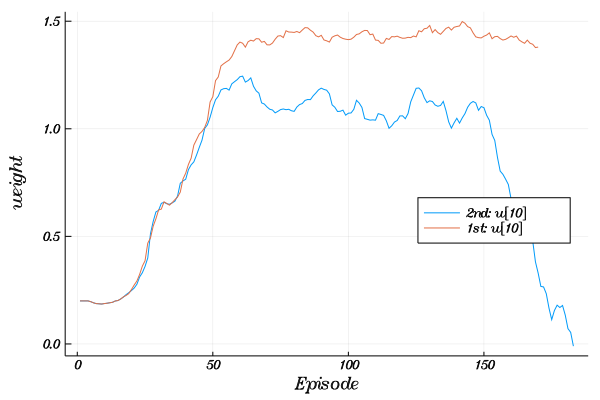

In [478]:
plot([w[10] for w in hook_2[4].ws], xlabel="Episode", ylabel="weight", label="2nd: w[10]", legend=:right)
plot!([w[10] for w in hook_1[4].ws], xlabel="Episode", ylabel="weight", label="1st: w[10]")